<a href="https://colab.research.google.com/github/Mochdioanugrah/Mini-Project-ML/blob/main/Yet_another_copy_of_Scrapping_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Mini Project **Klasifikasi** Berita hoax & non-hoax di indonesia **bold text**

**Instalasi Library Scraping**

In [ ]:
 !pip install requests beautifulsoup4

**Mount Google Drive & Setup Direktori**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # ikuti instruksi autentikasi
OUTPUT_DIR = "/content/drive/MyDrive/turnbackhoax_data"
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("OUTPUT_DIR:", OUTPUT_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
OUTPUT_DIR: /content/drive/MyDrive/turnbackhoax_data


**Pemeriksaan robots.txt (Compliance Scraping)**

In [ ]:
import requests
HEADERS = {"User-Agent": "ResearchBot/1.0 (+mailto:you@example.com)"}
r = requests.get("https://turnbackhoax.id/robots.txt", headers=HEADERS, timeout=20)
print("robots.txt status:", r.status_code)
print("--- robots.txt content ---")
print(r.text[:1000])  # tampilkan sebagian agar tidak terlalu panjang



robots.txt status: 200
--- robots.txt content ---
User-agent: *
Disallow: /wp-admin/
Allow: /wp-admin/admin-ajax.php

Sitemap: https://turnbackhoax.id/wp-sitemap.xml



**Scraping dan Ekstraksi Dataset Artikel Hoaks dari TurnBackHoax.id**

In [ ]:
import requests, time, csv, os, re, random
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
import pandas as pd

BASE_SITE = "https://turnbackhoax.id"
PAGE_URL = BASE_SITE + "/page/{}/"
HEADERS = {"User-Agent": "Mozilla/5.0 (compatible; ResearchBot/1.0; +mailto:you@example.com)"}

# OUTPUT: ganti kalau tidak mount Drive
OUTPUT_DIR = "/content/turnbackhoax_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)
RAW_HTML_DIR = os.path.join(OUTPUT_DIR, "raw_html")
os.makedirs(RAW_HTML_DIR, exist_ok=True)

# Set berapa banyak halaman yang mau di-scan
MAX_PAGES = 30         # ubah sesuai kebutuhan (jangan terlalu besar)
DELAY_MIN = 1.0
DELAY_MAX = 2.0

session = requests.Session()
session.headers.update(HEADERS)

def safe_filename(s):
    s = re.sub(r'[^0-9a-zA-Z\-_.]', '_', s)
    return s[:200]

def get_soup_from_url(url):
    r = session.get(url, timeout=30)
    if r.status_code != 200:
        return None, r.status_code, r.text
    return BeautifulSoup(r.text, "lxml"), r.status_code, r.text

def get_article_links_from_page(page_num):
    url = PAGE_URL.format(page_num)
    soup, status, raw = get_soup_from_url(url)
    if soup is None:
        return None, status
    links = []
    # Heuristik: ambil <article> lalu anchor, fallback ke selectors populer
    for art in soup.find_all("article"):
        a = art.find("a", href=True)
        if a:
            href = urljoin(BASE_SITE, a['href'])
            if href.startswith(BASE_SITE) and href not in links:
                links.append(href)
    if not links:
        # fallback selectors
        for sel in ["h2.entry-title a", "h3.entry-title a", "a[rel='bookmark']"]:
            for a in soup.select(sel):
                href = urljoin(BASE_SITE, a.get("href"))
                if href.startswith(BASE_SITE) and href not in links:
                    links.append(href)
    return links, status

def extract_label_from_soup(soup):
    # Coba cari elemen yang eksplisit (class mengandung verdict/label), lalu heuristik teks.
    candidates = []
    for tag in soup.find_all(True):
        cls = " ".join(tag.get("class") or [])
        if "verdict" in cls.lower() or "label" in cls.lower() or "status" in cls.lower() or "hasil" in cls.lower():
            txt = tag.get_text(" ", strip=True)
            if txt:
                candidates.append(txt)
    # heuristic: cari kata kunci umum
    text_top = ""
    content_top = soup.get_text(" ", strip=True)[:800].lower()
    keywords = ["hoax", "salah", "fakta", "benar", "misleading", "disinformasi", "provokasi"]
    for kw in keywords:
        if kw in content_top:
            # ambil kalimat yang mengandung keyword
            m = re.search(r'([^.!\n]{0,120}\b' + re.escape(kw) + r'\b[^.!\n]{0,120})', content_top)
            if m:
                candidates.append(m.group(1).strip())
    # return shortest candidate (lebih mungkin label ringkas), atau empty string
    if candidates:
        candidates = sorted(set(candidates), key=lambda x: len(x))
        # trim to 250 chars
        return candidates[0][:250]
    return ""

def parse_article(url):
    soup, status, raw = get_soup_from_url(url)
    if soup is None:
        return None, status
    # Simpan raw HTML untuk reproducibility
    parsed = urlparse(url)
    fname = safe_filename(parsed.path.strip("/").replace("/", "_") or parsed.netloc)
    with open(os.path.join(RAW_HTML_DIR, fname + ".html"), "w", encoding="utf-8") as f:
        f.write(raw)

    # Title
    title_tag = soup.find("h1", class_="entry-title") or soup.find("h1")
    title = title_tag.get_text(" ", strip=True) if title_tag else ""

    # Date
    date_tag = soup.find("time", class_="entry-date") or soup.find("time")
    date = date_tag.get("datetime") if date_tag and date_tag.get("datetime") else (date_tag.get_text(" ", strip=True) if date_tag else "")

    # Content
    content_div = soup.find("div", class_=re.compile(r"(post-content|entry-content|td-post-content|post-body)")) or soup.find("article")
    if content_div:
        paragraphs = [p.get_text(" ", strip=True) for p in content_div.find_all("p")]
        content = "\n\n".join([p for p in paragraphs if p])
    else:
        content = soup.get_text(" ", strip=True)[:2000]

    # Label / verdict (heuristic)
    label = extract_label_from_soup(soup)

    return {
        "url": url,
        "title": title,
        "date": date,
        "label": label,
        "content": content
    }, 200

# === RUN SCRAPE ===
all_records = []
seen_urls = set()
for page in range(1, MAX_PAGES + 1):
    print(f"Scanning page {page} ...", end=" ")
    links_status = get_article_links_from_page(page)
    if links_status is None:
        print("failed or 404, stop.")
        break
    links, status = links_status
    if not links:
        print("no links (empty) — stop.")
        break
    print(f"found {len(links)} links")
    for link in links:
        if link in seen_urls:
            continue
        try:
            rec, code = parse_article(link)
            if rec:
                all_records.append(rec)
                seen_urls.add(link)
                print(" -", rec["title"][:80])
            else:
                print(" - failed parse:", link, code)
        except Exception as e:
            print(" - error parsing:", e)
        time.sleep(random.uniform(DELAY_MIN, DELAY_MAX))
    # jeda antar halaman
    time.sleep(random.uniform(DELAY_MIN, DELAY_MAX))

# Simpan CSV
df = pd.DataFrame(all_records)
CSV_PATH = os.path.join(OUTPUT_DIR, "turnbackhoax_data.csv")
df.to_csv(CSV_PATH, index=False)
print("Saved", len(df), "records to", CSV_PATH)
# Show preview
df.head(10)

Scanning page 1 ... found 20 links
 - [SALAH] KTP-el Dipasang GPS untuk Pantau Keberadaan Masyarakat
 - [SALAH] Jokowi Setuju RUU Perampasan Aset, Asalkan Tidak Menyasar Mantan Preside
 - [SALAH] Israel Ngambek dan Keluar dari Sidang PBB Ketika Hampir Semua Negara Sep
 - [PENIPUAN] PLN Tawarkan Listrik Gratis Lewat Akun TikTok
 - [SALAH] Ojol Demo Kenaikan Pertalite
 - [SALAH] Panglima NATO akan Buat Kerusuhan di Indonesia
 - [SALAH] Ojol Dilarang Gunakan Pertalite
 - [SALAH] Video Pengiriman 18.000 Personel TNI ke Aceh
 - [SALAH] Pom Bensin Shell Resmi Tutup dan Hengkang dari Indonesia pada 2026
 - [SALAH] Menteri ESDM Bahlil Lahadalia Jadi Tersangka Kasus Korupsi Migas
 - [PENIPUAN] Wapres Gibran Promosikan Program Motor Murah
 - [SALAH] Mobil Ahmad Sahroni Dikepung di Tengah Demo Mahasiswa
 - [SALAH] Gatot Nurmantyo Resmi Jadi Menko Polkam
 - [SALAH] Prabowo Ungkap Gatot Nurmantyo dan Rocky Gerung Masuk Kabinet Merah Puti
 - [SALAH] KPK Panggil Megawati Untuk Diperiksa
 - [PENIPUAN]

,url,title,date,label,content
0,https://turnbackhoax.id/2025/09/30/salah-ktp-e...,[SALAH] KTP-el Dipasang GPS untuk Pantau Keber...,,[salah] ktp-el dipasang gps untuk pantau keber...,Akun Instagram “ 1273alam ” [ arsip ] pada Kam...
1,https://turnbackhoax.id/2025/09/30/salah-jokow...,"[SALAH] Jokowi Setuju RUU Perampasan Aset, Asa...",,"[salah] jokowi setuju ruu perampasan aset, asa...",Pada Selasa (23/9/2025) akun Facebook “Himae H...
2,https://turnbackhoax.id/2025/09/30/salah-israe...,[SALAH] Israel Ngambek dan Keluar dari Sidang ...,,[salah] israel ngambek dan keluar dari sidang ...,Pada Selasa (23/09/2025) akun Tiktok “majuidn”...
3,https://turnbackhoax.id/2025/09/30/penipuan-pl...,[PENIPUAN] PLN Tawarkan Listrik Gratis Lewat A...,,tim pemeriksa fakta mafindo (turnbackhoax) men...,Tim Pemeriksa Fakta Mafindo (TurnBackHoax) men...
4,https://turnbackhoax.id/2025/09/30/salah-ojol-...,[SALAH] Ojol Demo Kenaikan Pertalite,,[salah] ojol demo kenaikan pertalite – turnbac...,Beredar video [arsip] dari akun tiktok “kampun...
5,https://turnbackhoax.id/2025/09/30/salah-pangl...,[SALAH] Panglima NATO akan Buat Kerusuhan di I...,,[salah] panglima nato akan buat kerusuhan di i...,Akun TikTok “pasukankhususalmadi7” pada Senin ...
6,https://turnbackhoax.id/2025/09/30/salah-ojol-...,[SALAH] Ojol Dilarang Gunakan Pertalite,,[salah] ojol dilarang gunakan pertalite – turn...,Pada Sabtu (20/9/2025) akun TikTok “Mr.J-Skull...
7,https://turnbackhoax.id/2025/09/30/salah-video...,[SALAH] Video Pengiriman 18.000 Personel TNI k...,,[salah] video pengiriman 18,Akun Facebook “Muchtadil Hebat Anwar” pada Sab...
8,https://turnbackhoax.id/2025/09/30/salah-pom-b...,[SALAH] Pom Bensin Shell Resmi Tutup dan Hengk...,,[salah] pom bensin shell resmi tutup dan hengk...,Beredar unggahan [arsip] dari akun Facebook “K...
9,https://turnbackhoax.id/2025/09/29/salah-mente...,[SALAH] Menteri ESDM Bahlil Lahadalia Jadi Ter...,,[salah] menteri esdm bahlil lahadalia jadi ter...,Akun Facebook “Bima Silhoute” pada Jumat (26 /...


**Mengecek File Output dan Mengunduh Dataset Hasil Scraping**

In [ ]:
# cek file di /content
import os
print("files in output:", os.listdir("/content/turnbackhoax_data")[:30])
# download
from google.colab import files
files.download("/content/turnbackhoax_data/turnbackhoax_data.csv")


files in output: ['raw_html', 'turnbackhoax_data.csv']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Memuat Dataset Detik & TurnBackHoax serta Mengecek Struktur Awal**

In [ ]:
import pandas as pd

# Membaca kedua file
detik = pd.read_csv("detik_non_hoax_full Scraping.csv")
turnback = pd.read_csv("turnbackhoax_data (2).csv")

# Menampilkan struktur dasar
print("Detik:", detik.shape)
print("TurnBackHoax:", turnback.shape)


Detik: (3893, 3)
TurnBackHoax: (2900, 5)


**Pra-Pemrosesan Data**

In [ ]:
import pandas as pd
import re

# =========================================
# 1. Membaca dataset
# =========================================
turnbackhoax_path = "turnbackhoax_data (2).csv"
detik_path = "detik_non_hoax_full Scraping.csv"

df_turnbackhoax = pd.read_csv(turnbackhoax_path, encoding="utf-8")
df_detik = pd.read_csv(detik_path, encoding="utf-8")

print("Data Turnbackhoax:", df_turnbackhoax.shape)
print("Data Detik Non-hoax:", df_detik.shape)

# =========================================
# 2. Seleksi hanya berita hoaks
# =========================================
mask_hoax = df_turnbackhoax["title"].str.contains(
    "HOAKS|SALAH|DISINFORMASI|MISLEADING|FALSE|FABRICATED|PENIPUAN",
    case=False, na=False
)
df_turnbackhoax = df_turnbackhoax[mask_hoax]

print("Data Turnbackhoax setelah seleksi hoaks:", df_turnbackhoax.shape)

# =========================================
# 3. Bersihkan judul (untuk konsistensi, meski nanti tidak dipakai)
# =========================================
def clean_title(title):
    title = re.sub(r'\[(HOAKS|SALAH|DISINFORMASI|MISLEADING|FALSE|FABRICATED|PENIPUAN)\]', '', title, flags=re.IGNORECASE)
    title = re.sub(r'\s+', ' ', title).strip()
    return title

df_turnbackhoax["title"] = df_turnbackhoax["title"].apply(clean_title)

# =========================================
# 4. Pilih hanya kolom ISI berita (discard judul)
# =========================================
df_turnbackhoax = df_turnbackhoax[["content"]].rename(columns={"content": "isi"})
df_detik = df_detik[["isi_berita"]].rename(columns={"isi_berita": "isi"})

# =========================================
# 5. Tambah label
# =========================================
df_turnbackhoax["label"] = "hoaks"
df_detik["label"] = "non-hoaks"

# =========================================
# 6. Gabungkan dataset
# =========================================
df_combined = pd.concat([df_turnbackhoax, df_detik], ignore_index=True)

# =========================================
# 7. Hapus duplikat & missing
# =========================================
df_combined.drop_duplicates(subset=["isi"], inplace=True)
df_combined.dropna(subset=["isi"], inplace=True)

# =========================================
# 8. Cek hasil
# =========================================
print("\nJumlah total data:", len(df_combined))
print("\nDistribusi label:")
print(df_combined["label"].value_counts())

print("\nContoh data:")
print(df_combined.sample(5))

# =========================================
# 9. Simpan final dataset
# =========================================
output_path = "dataset_hoax_vs_nonhoax_only_isi.csv"
df_combined.to_csv(output_path, index=False, encoding="utf-8")
print(f"\n✅ Dataset final disimpan ke: {output_path}")


Data Turnbackhoax: (2900, 5)
Data Detik Non-hoax: (3893, 3)
Data Turnbackhoax setelah seleksi hoaks: (2870, 5)

Jumlah total data: 6760

Distribusi label:
label
non-hoaks    3891
hoaks        2869
Name: count, dtype: int64

Contoh data:
                                                    isi      label
6384  Tiket MotoGP Mandalika di Lombok Timur, Nusa T...  non-hoaks
1911  Hasil periksa fakta Moch. MarcellodiansyahFakt...      hoaks
2031  Hasil Periksa Fakta Dyah FegriyaniVideo terseb...      hoaks
1998  Hasil periksa fakta Rahmah.Kemendikbud memasti...      hoaks
409   Hasil periksa fakta Yudho ArdiInformasi yang m...      hoaks

✅ Dataset final disimpan ke: dataset_hoax_vs_nonhoax_only_isi.csv


# PREPROCESSING

In [ ]:
import pandas as pd

# Membaca dataset gabungan
df = pd.read_csv("dataset_hoax_vs_nonhoax_only_isi.csv")

# Menampilkan 5 data teratas
print("Contoh data sebelum preprocessing:")
print(df.head())


**1. Case Folding pada Kolom Isi Berita (Normalisasi Huruf Kecil)**

In [ ]:
import pandas as pd

# 1. Load dataset gabungan
df = pd.read_csv("dataset_hoax_vs_nonhoax_only_isi.csv")

# 2. Case Folding hanya pada kolom ISI
df["isi_casefold"] = df["isi"].astype(str).str.lower()

# 3. Tampilkan contoh hasil
print("Sebelum Case Folding:\n", df["isi"].iloc[0])
print("\nSesudah Case Folding:\n", df["isi_casefold"].iloc[0])


**2. Text Cleaning (Noise Removal)**

In [ ]:
import re

def clean_text(text):
    # hapus tag label hoax di awal kalimat
    text = re.sub(r"\[(hoax|salah|disinformasi|misleading|false|fabricated|penipuan)\]", "", text, flags=re.IGNORECASE)

    # hapus URL
    text = re.sub(r"http\S+|www\S+", "", text)

    # hapus angka, simbol, tanda baca
    text = re.sub(r"[^a-zA-Z\s]", " ", text)

    # hapus spasi berlebih
    text = re.sub(r"\s+", " ", text).strip()

    return text

# proses hanya kolom isi
df["isi_bersih"] = df["isi_casefold"].apply(clean_text)

print("Sebelum Cleaning:\n", df["isi_casefold"].iloc[0])
print("\nSesudah Cleaning:\n", df["isi_bersih"].iloc[0])


**3. Tokenisasi Teks: Pemecahan Kalimat menjadi Token Kata (NLTK Word Tokenizer)**

In [ ]:
pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
import nltk
from nltk.tokenize import word_tokenize

# Download tokenizer NLTK (wajib dua ini untuk versi terbaru)
nltk.download('punkt')
nltk.download('punkt_tab')

# Tokenisasi hanya pada kolom isi
df["token_isi"] = df["isi_bersih"].apply(word_tokenize)

# Contoh output
print("Sebelum Tokenisasi (isi):")
print(df["isi_bersih"].iloc[0])

print("\nSesudah Tokenisasi (isi):")
print(df["token_isi"].iloc[0])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Sebelum Tokenisasi (isi):
faktanya belum ada dukungan resmi anies untuk pasangan manapun di pilkada jakarta unggahan berisi informasi anies baswedan mendukung calon gubernur dan wakil gubernur nomor urut pramono rano merupakan konten yang menyesatkan misleading content akun instagram lintang son o pada sabtu mengunggahvideo arsip yang memperlihatkan anies mengacungkan jari unggahan disertai takarir anies baswedan mendukung calon gubernur dan wakil gubernur nomor urut mas pram bang doelper rabu konten dilihat hampir kali dan disukai akun pemeriksaan faktadisadur dari artikel periksa fakta tirto id tim pemeriksa fakta tirto melakukan penelusuran dengan membuka media sosial anies melalui akun instagramnya aniesbaswedan terdapat foto anies yang sedang memakai batik dan mengendarai sepeda pada unggahan rabu dalam narasi yang dibagikan anies pada saat itu hanya memperingati hari batik nasional dan hari sepeda nasional bersama kelompok bike to work indonesia tirto melanjutkan penelusuran deng

**4. Stopword Removal: Menghapus Kata Umum Bahasa Indonesia (NLTK Stopwords)**

In [ ]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if belum ada
nltk.download('stopwords')

# Load stopwords bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

# Hapus stopword pada kolom isi
df["token_isi_tanpa_stopword"] = df["token_isi"].apply(
    lambda tokens: [w for w in tokens if w not in stop_words]
)

# Tampilkan contoh hasil
print("Sebelum Stopword Removal:", df["token_isi"].iloc[0][:20])
print("Sesudah Stopword Removal:", df["token_isi_tanpa_stopword"].iloc[0][:20])


Sebelum Stopword Removal: ['faktanya', 'belum', 'ada', 'dukungan', 'resmi', 'anies', 'untuk', 'pasangan', 'manapun', 'di', 'pilkada', 'jakarta', 'unggahan', 'berisi', 'informasi', 'anies', 'baswedan', 'mendukung', 'calon', 'gubernur']
Sesudah Stopword Removal: ['faktanya', 'dukungan', 'resmi', 'anies', 'pasangan', 'manapun', 'pilkada', 'jakarta', 'unggahan', 'berisi', 'informasi', 'anies', 'baswedan', 'mendukung', 'calon', 'gubernur', 'wakil', 'gubernur', 'nomor', 'urut']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**5. Stemming Bahasa Indonesia Menggunakan Library Sastrawi**

In [ ]:


  from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Membuat stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Stemming pada kolom isi (hasil token tanpa stopword)
df["stem_isi"] = df["token_isi_tanpa_stopword"].apply(lambda tokens: [stemmer.stem(w) for w in tokens])

# Contoh output
print("Sebelum Stemming (isi):", df["token_isi_tanpa_stopword"].iloc[0][:10])
print("Sesudah Stemming (isi):", df["stem_isi"].iloc[0][:10])


Sebelum Stemming (isi): ['faktanya', 'dukungan', 'resmi', 'anies', 'pasangan', 'manapun', 'pilkada', 'jakarta', 'unggahan', 'berisi']
Sesudah Stemming (isi): ['fakta', 'dukung', 'resmi', 'anies', 'pasang', 'mana', 'pilkada', 'jakarta', 'unggah', 'isi']


**6. Menggabungkan Token Hasil Stemming Menjadi Kalimat Utuh**

In [ ]:
# Gabungkan kembali token menjadi kalimat utuh
df["teks_final"] = df["stem_isi"].apply(lambda x: " ".join(x))

print("Contoh Teks Final:", df["teks_final"].iloc[0])


Contoh Teks Final: fakta dukung resmi anies pasang mana pilkada jakarta unggah isi informasi anies baswedan dukung calon gubernur wakil gubernur nomor urut pramono rano konten sesat misleading content akun instagram lintang son o sabtu mengunggahvideo arsip anies acung jari unggah serta takarir anies baswedan dukung calon gubernur wakil gubernur nomor urut mas pram bang doelper rabu konten kali suka akun periksa faktadisadur artikel periksa fakta tirto id tim periksa fakta tirto telusur buka media sosial anies akun instagramnya aniesbaswedan foto anies pakai batik kendara sepeda unggah rabu narasi bagi anies ingat batik nasional sepeda nasional kelompok bike to work indonesia tirto lanjut telusur kunci dukung anies pilkada jakarta google hasil salah artikel tempo judul jubir anies baswedan nyata dukung pilkada jakarta juru bicara anies sahrin hamid anies dukung resmi satu pasang calon gubernur wakil gubernur pilkada jakarta jumat pihak rakyat lemah perhati mas anies tentu pilih tunggu 

**7. Menyimpan Dataset Hasil Preprocessing ke File CSV**

In [ ]:
df.to_csv("dataset_preprocessed_final.csv", index=False, encoding="utf-8")
print("✅ Dataset hasil preprocessing disimpan ke: dataset_preprocessed_final.csv")


✅ Dataset hasil preprocessing disimpan ke: dataset_preprocessed_final.csv


**Encoding Label: Konversi Hoaks (1) dan Non-Hoaks (0)bold text**

In [ ]:
import pandas as pd

# 1️⃣ Load dataset hasil preprocessing (tahap sebelumnya)
df = pd.read_csv("dataset_preprocessed_final.csv")

# 2️⃣ Encoding label (ubah hoaks → 1, non-hoaks → 0)
df["label_num"] = df["label"].map({"non-hoaks": 0, "hoaks": 1})

# 3️⃣ Cek keberhasilan encoding
print("\n✅ Contoh Encoding Label:")
print(df[["label", "label_num"]].head(10))

print("\n📊 Jumlah data per kelas:")
print(df["label_num"].value_counts())

# 4️⃣ Simpan dataset final setelah encoding label
output_path = "dataset_ready_for_feature_extraction.csv"
df.to_csv(output_path, index=False, encoding="utf-8")

print(f"\n💾 Dataset final disimpan sebagai: {output_path}")



✅ Contoh Encoding Label:
   label  label_num
0  hoaks          1
1  hoaks          1
2  hoaks          1
3  hoaks          1
4  hoaks          1
5  hoaks          1
6  hoaks          1
7  hoaks          1
8  hoaks          1
9  hoaks          1

📊 Jumlah data per kelas:
label_num
0    3891
1    2869
Name: count, dtype: int64

💾 Dataset final disimpan sebagai: dataset_ready_for_feature_extraction.csv


**Exploratory View: Sampel Kolom teks_final dan label_num**

In [ ]:
import pandas as pd

# Load dataset final yang sudah kamu upload
df = pd.read_csv("dataset_ready_for_feature_extraction.csv")

# Tampilkan 20 baris pertama kolom teks_final dan label_num
df[["teks_final", "label_num"]].head(20)


,teks_final,label_num
0,fakta dukung resmi anies pasang mana pilkada j...,1
1,sumber valid benar presiden prabowo ancam nara...,1
2,nyata menkes budi lockdown great reset narasi ...,1
3,hasil cari google arah pemberitaancnbc indones...,1
4,kpk bukti kuat libat pramono puan korupsi e kt...,1
5,warganet periksa media sosial milik king kevin...,1
6,akun instagram resmi ditjenpajakri djp modus t...,1
7,lembaga kredibel rilis hasil survei tanggal in...,1
8,fakta temu informasi sumber kredibel pks mundu...,1
9,taut unggah edar arah tipu akun facebook dafta...,1


# Proses Ekstraksi Fitur Menggunakan TF-IDF Vectorization

In [ ]:
# ==============================
# 📦 1. Import Library
# ==============================
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# ==============================
# 📂 2. Load Dataset
# ==============================
df = pd.read_csv("dataset_ready_for_feature_extraction.csv")

# Ambil kolom teks dan label
X_text = df["teks_final"].astype(str)
y = df["label_num"]

# ==============================
# 🔠 3. TF-IDF Vectorization
# ==============================
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,     # ambil 5000 kata paling penting
    sublinear_tf=True,     # normalisasi logaritmik TF
    encoding='utf-8',
)

X_tfidf = tfidf_vectorizer.fit_transform(X_text)

# ==============================
# 📊 4. Info Bentuk Matriks
# ==============================
print("✅ TF-IDF selesai diekstraksi.")
print("📏 Bentuk matriks TF-IDF:", X_tfidf.shape)

# ==============================
# 🔍 5. Contoh Nilai TF-IDF (non-zero)
# ==============================
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(X_tfidf[:5].toarray(), columns=feature_names)

for i in range(5):
    print(f"\n📰 Dokumen {i+1}:")
    nonzero = tfidf_df.loc[i][tfidf_df.loc[i] > 0]
    print(nonzero.sort_values(ascending=False).head(10))  # tampilkan 10 kata terpenting per dokumen

# ==============================
# 💾 6. Simpan hasil ekstraksi TF-IDF
# ==============================
scipy.sparse.save_npz("tfidf_features.npz", X_tfidf)

print("\n💾 Hasil ekstraksi TF-IDF berhasil disimpan!")
print("📂 File fitur: tfidf_features.npz")
print("📏 Bentuk fitur:", X_tfidf.shape)


✅ TF-IDF selesai diekstraksi.
📏 Bentuk matriks TF-IDF: (6760, 5000)

📰 Dokumen 1:
anies       0.305029
pilkada     0.264565
gubernur    0.243599
tirto       0.221707
rano        0.218156
baswedan    0.213974
calon       0.201270
urut        0.191479
batik       0.185898
mas         0.164271
Name: 0, dtype: float64

📰 Dokumen 2:
aparatur      0.322623
prabowo       0.246483
ancam         0.243710
rakyat        0.239616
fabricated    0.220051
urus          0.210558
pimpin        0.208759
presiden      0.187179
valid         0.184254
negara        0.152427
Name: 1, dtype: float64

📰 Dokumen 3:
menkes        0.313770
pandemic      0.271661
budi          0.254752
pandemi       0.246330
order         0.230614
new           0.175992
agenda        0.171384
gagas         0.158006
world         0.155813
misleading    0.136996
Name: 2, dtype: float64

📰 Dokumen 4:
militer       0.308229
wajib         0.245363
putri         0.213269
prabowo       0.211409
putra         0.204693
rakyat        0.197

**Contoh Representasi TF-IDF (10 Fitur Teratas)**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=10)  # ambil 10 kata teratas agar tabel tidak terlalu besar
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

# 4️⃣ Buat DataFrame hasil ekstraksi
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
).round(3)

# 5️⃣ Ambil hanya baris yang punya nilai TF-IDF ≠ 0.0
tfidf_nonzero = tfidf_df[(tfidf_df != 0).any(axis=1)]

# 6️⃣ Tampilkan hanya beberapa baris agar tabel ringkas
print("📊 Contoh representasi hasil ekstraksi TF-IDF (hanya bobot ≠ 0.0):")
print(tfidf_nonzero.head(10))


📊 Contoh representasi hasil ekstraksi TF-IDF (hanya bobot ≠ 0.0):
    akun  content  fakta  hasil  indonesia  konten  periksa   temu  unggah  \
0  0.481    0.228  0.394  0.113      0.143   0.405    0.383  0.000   0.467   
1  0.192    0.273  0.158  0.135      0.000   0.486    0.153  0.167   0.747   
2  0.429    0.305  0.352  0.000      0.191   0.543    0.171  0.187   0.417   
3  0.362    0.257  0.148  0.510      0.323   0.305    0.144  0.158   0.527   
4  0.393    0.279  0.322  0.138      0.351   0.497    0.313  0.171   0.382   
5  0.900    0.116  0.134  0.000      0.000   0.207    0.261  0.071   0.159   
6  0.332    0.472  0.272  0.000      0.000   0.560    0.529  0.000   0.000   
7  0.553    0.157  0.091  0.545      0.099   0.186    0.176  0.000   0.537   
8  0.411    0.292  0.337  0.289      0.183   0.346    0.327  0.358   0.399   
9  0.639    0.227  0.131  0.000      0.000   0.269    0.255  0.000   0.621   

   video  
0  0.000  
1  0.000  
2  0.174  
3  0.000  
4  0.000  
5  0.133 

# Ekstraksi Fitur Word2Vec: Pelatihan Model & Representasi Dokumen

In [ ]:
pip install gensim


In [ ]:
# ================================================================
# 📦 1. Import Library
# ================================================================
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import joblib

# ================================================================
# 📂 2. Load Dataset
# ================================================================
df = pd.read_csv("dataset_ready_for_feature_extraction.csv")

# Ambil kolom teks saja
X_text = df["teks_final"].astype(str)

# ================================================================
# 🧠 3. Word2Vec Feature Extraction
# ================================================================
print("🔹 Ekstraksi fitur Word2Vec dimulai...")

# 3.1 Tokenisasi sederhana (ubah teks jadi list kata)
sentences = [text.split() for text in X_text]

# 3.2 Latih model Word2Vec
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,   # dimensi vektor tiap kata
    window=5,          # konteks kata (5 kata di sekitar)
    min_count=2,       # hanya kata muncul ≥2 kali yang dilatih
    workers=4,
    sg=1               # gunakan skip-gram (lebih baik untuk data kecil)
)

# Simpan model Word2Vec agar bisa digunakan lagi nanti
w2v_model.save("word2vec_model.model")

print("✅ Model Word2Vec selesai dilatih.")
print("📏 Jumlah kata dalam kosakata model:", len(w2v_model.wv.index_to_key))

# ================================================================
# 🧩 4. Representasi Dokumen
# ================================================================
# Fungsi untuk menghitung rata-rata vektor dari kata-kata dalam 1 dokumen
def document_vector(doc):
    words = [word for word in doc if word in w2v_model.wv.index_to_key]
    if len(words) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(w2v_model.wv[words], axis=0)

# 4.1 Ubah semua dokumen menjadi vektor
X_w2v = np.array([document_vector(doc) for doc in sentences])

print("✅ Dokumen berhasil diubah menjadi vektor.")
print("📏 Bentuk matriks Word2Vec:", X_w2v.shape)

# ================================================================
# 💾 5. Simpan Hasil Ekstraksi
# ================================================================
joblib.dump(X_w2v, "word2vec_features.joblib")

print("\n💾 Fitur Word2Vec disimpan sebagai 'word2vec_features.joblib'")
print("Model Word2Vec disimpan sebagai 'word2vec_model.model'")


🔹 Ekstraksi fitur Word2Vec dimulai...
✅ Model Word2Vec selesai dilatih.
📏 Jumlah kata dalam kosakata model: 23891
✅ Dokumen berhasil diubah menjadi vektor.
📏 Bentuk matriks Word2Vec: (6760, 100)

💾 Fitur Word2Vec disimpan sebagai 'word2vec_features.joblib'
Model Word2Vec disimpan sebagai 'word2vec_model.model'


# Train–Test Split untuk Fitur TF-IDF

In [ ]:
# ==============================
# 📦 1. Import Library
# ==============================
from sklearn.model_selection import train_test_split
import joblib
import scipy.sparse
import pandas as pd


In [ ]:
# ==============================
# 📂 2. Load Data
# ==============================
# Baca dataset untuk mengambil label
df = pd.read_csv("dataset_ready_for_feature_extraction.csv")
y = df["label_num"]

# 🔹 Load TF-IDF
X_tfidf = scipy.sparse.load_npz("tfidf_features.npz")

# 🔹 Load Word2Vec
X_w2v = joblib.load("word2vec_features.joblib")


In [ ]:
# ==============================
# 📂 2. Load Data
# ==============================
# Baca dataset untuk mengambil label
df = pd.read_csv("dataset_ready_for_feature_extraction.csv")
y = df["label_num"]

# 🔹 Load TF-IDF
X_tfidf = scipy.sparse.load_npz("tfidf_features.npz")

# 🔹 Load Word2Vec
X_w2v = joblib.load("word2vec_features.joblib")


# ==============================
# ✂️ 3. Split Dataset (TF-IDF)
# ==============================
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y,
    test_size=0.2,         # 80% train, 20% test
    random_state=42,       # untuk hasil yang konsisten
    stratify=y             # agar proporsi label tetap sama
)

print("✅ TF-IDF berhasil di-split.")
print("📏 Train:", X_train_tfidf.shape, " Test:", X_test_tfidf.shape)
print("🔸 Distribusi label Train:\n", y_train_tfidf.value_counts(normalize=True))
print("🔹 Distribusi label Test:\n", y_test_tfidf.value_counts(normalize=True))


✅ TF-IDF berhasil di-split.
📏 Train: (5408, 5000)  Test: (1352, 5000)
🔸 Distribusi label Train:
 label_num
0    0.575629
1    0.424371
Name: proportion, dtype: float64
🔹 Distribusi label Test:
 label_num
0    0.575444
1    0.424556
Name: proportion, dtype: float64


# Train–Test Split untuk Fitur Word2Vec

In [ ]:
# ==============================
# ✂️ 4. Split Dataset (Word2Vec)
# ==============================
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_w2v, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\n✅ Word2Vec berhasil di-split.")
print("📏 Train:", X_train_w2v.shape, " Test:", X_test_w2v.shape)
print("🔸 Distribusi label Train:\n", y_train_w2v.value_counts(normalize=True))
print("🔹 Distribusi label Test:\n", y_test_w2v.value_counts(normalize=True))



✅ Word2Vec berhasil di-split.
📏 Train: (5408, 100)  Test: (1352, 100)
🔸 Distribusi label Train:
 label_num
0    0.575629
1    0.424371
Name: proportion, dtype: float64
🔹 Distribusi label Test:
 label_num
0    0.575444
1    0.424556
Name: proportion, dtype: float64


**Menyimpan hasil split Dataset**

In [ ]:
# ==============================
# 💾 5. Simpan Hasil Split
# ==============================
joblib.dump((X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf), "split_tfidf.joblib")
joblib.dump((X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v), "split_word2vec.joblib")

print("\n💾 Split dataset berhasil disimpan!")



💾 Split dataset berhasil disimpan!


# **Balancing Data Menggunakan SMOTE**

In [ ]:
# ==============================
# 📦 1. Import Library
# ==============================
from imblearn.over_sampling import SMOTE
import joblib
import pandas as pd

# ==============================
# 📂 2. Load Hasil Split Dataset
# ==============================
# Ambil hasil split dari tahap sebelumnya (TF-IDF dan Word2Vec)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = joblib.load("split_tfidf.joblib")
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = joblib.load("split_word2vec.joblib")

# ==============================
# ⚖️ 3. Balancing Data (SMOTE)
# ==============================
print("🔹 Proses SMOTE dimulai...")

# Inisialisasi SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto')

# --- TF-IDF ---
X_train_tfidf_bal, y_train_tfidf_bal = smote.fit_resample(X_train_tfidf, y_train_tfidf)
print("\n✅ SMOTE (TF-IDF) selesai.")
print("📏 Sebelum SMOTE:", X_train_tfidf.shape, " | Sesudah SMOTE:", X_train_tfidf_bal.shape)
print("📊 Distribusi label sesudah SMOTE (TF-IDF):")
print(pd.Series(y_train_tfidf_bal).value_counts())

# --- Word2Vec ---
X_train_w2v_bal, y_train_w2v_bal = smote.fit_resample(X_train_w2v, y_train_w2v)
print("\n✅ SMOTE (Word2Vec) selesai.")
print("📏 Sebelum SMOTE:", X_train_w2v.shape, " | Sesudah SMOTE:", X_train_w2v_bal.shape)
print("📊 Distribusi label sesudah SMOTE (Word2Vec):")
print(pd.Series(y_train_w2v_bal).value_counts())

# ==============================
# 💾 4. Simpan Hasil SMOTE
# ==============================
joblib.dump((X_train_tfidf_bal, y_train_tfidf_bal, X_test_tfidf, y_test_tfidf), "balanced_tfidf.joblib")
joblib.dump((X_train_w2v_bal, y_train_w2v_bal, X_test_w2v, y_test_w2v), "balanced_word2vec.joblib")

print("\n💾 Hasil balancing (SMOTE) berhasil disimpan!")
print("📂 File: balanced_tfidf.joblib & balanced_word2vec.joblib")


🔹 Proses SMOTE dimulai...

✅ SMOTE (TF-IDF) selesai.
📏 Sebelum SMOTE: (5408, 5000)  | Sesudah SMOTE: (6226, 5000)
📊 Distribusi label sesudah SMOTE (TF-IDF):
label_num
0    3113
1    3113
Name: count, dtype: int64

✅ SMOTE (Word2Vec) selesai.
📏 Sebelum SMOTE: (5408, 100)  | Sesudah SMOTE: (6226, 100)
📊 Distribusi label sesudah SMOTE (Word2Vec):
label_num
0    3113
1    3113
Name: count, dtype: int64

💾 Hasil balancing (SMOTE) berhasil disimpan!
📂 File: balanced_tfidf.joblib & balanced_word2vec.joblib


# Seleksi Fitur (Chi-Square, ANOVA F-test, Mutual Information)

In [ ]:
# ================================================================
# 📦 1. Import Library
# ================================================================
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import joblib
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

# ================================================================
# 📂 2. Load Data Hasil SMOTE (TF-IDF)
# ================================================================
data_tfidf = joblib.load("balanced_tfidf.joblib")

# Unpack sesuai urutan (train_X, train_y, test_X, test_y)
X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf = data_tfidf

print("✅ Data TF-IDF hasil SMOTE berhasil dimuat.")
print("📏 Bentuk fitur (train):", X_train_tfidf.shape)
print("📊 Distribusi label:")
print(y_train_tfidf.value_counts())

# Pastikan label dalam bentuk array numerik
y_train_tfidf = np.array(y_train_tfidf, dtype=int)

# ================================================================
# ⚙️ 3. Seleksi Fitur (3 Metode)
# ================================================================
K = 2000  # jumlah fitur terpilih

# -----------------------------
# 3.1 Chi-Square
# -----------------------------
chi2_selector = SelectKBest(score_func=chi2, k=K)
X_train_chi2 = chi2_selector.fit_transform(X_train_tfidf, y_train_tfidf)
X_test_chi2 = chi2_selector.transform(X_test_tfidf)

chi2_scores = chi2_selector.scores_
chi2_mean = np.nanmean(chi2_scores)
chi2_top_idx = np.argsort(chi2_scores)[-10:][::-1]

print("\n🔹 Chi-Square")
print(f"   ➜ {X_train_tfidf.shape} → {X_train_chi2.shape}")
print(f"   📈 Rata-rata skor fitur: {chi2_mean:.4f}")
print(f"   🏆 Top 10 fitur terbaik (index): {chi2_top_idx.tolist()}")

# -----------------------------
# 3.2 ANOVA F-test
# -----------------------------
anova_selector = SelectKBest(score_func=f_classif, k=K)
X_train_anova = anova_selector.fit_transform(X_train_tfidf, y_train_tfidf)
X_test_anova = anova_selector.transform(X_test_tfidf)

anova_scores = anova_selector.scores_
anova_mean = np.nanmean(anova_scores)
anova_top_idx = np.argsort(anova_scores)[-10:][::-1]

print("\n🔹 ANOVA F-test")
print(f"   ➜ {X_train_tfidf.shape} → {X_train_anova.shape}")
print(f"   📈 Rata-rata skor fitur: {anova_mean:.4f}")
print(f"   🏆 Top 10 fitur terbaik (index): {anova_top_idx.tolist()}")

# -----------------------------
# 3.3 Mutual Information
# -----------------------------
mi_selector = SelectKBest(score_func=mutual_info_classif, k=K)
X_train_mi = mi_selector.fit_transform(X_train_tfidf, y_train_tfidf)
X_test_mi = mi_selector.transform(X_test_tfidf)

mi_scores = mi_selector.scores_
mi_mean = np.nanmean(mi_scores)
mi_top_idx = np.argsort(mi_scores)[-10:][::-1]

print("\n🔹 Mutual Information")
print(f"   ➜ {X_train_tfidf.shape} → {X_train_mi.shape}")
print(f"   📈 Rata-rata skor fitur: {mi_mean:.4f}")
print(f"   🏆 Top 10 fitur terbaik (index): {mi_top_idx.tolist()}")

# ================================================================
# 💾 4. Simpan Hasil Seleksi Fitur
# ================================================================
joblib.dump((X_train_chi2, X_test_chi2, y_train_tfidf, y_test_tfidf), "selected_features_chi2.joblib")
joblib.dump((X_train_anova, X_test_anova, y_train_tfidf, y_test_tfidf), "selected_features_anova.joblib")
joblib.dump((X_train_mi, X_test_mi, y_train_tfidf, y_test_tfidf), "selected_features_mi.joblib")

print("\n💾 Hasil seleksi fitur berhasil disimpan!")
print("📂 File:")
print(" - selected_features_chi2.joblib")
print(" - selected_features_anova.joblib")
print(" - selected_features_mi.joblib")

# ================================================================
# 🧾 5. Ringkasan Perbandingan
# ================================================================
comparison = pd.DataFrame({
    "Metode": ["Chi-Square", "ANOVA F-test", "Mutual Information"],
    "Fitur Awal": [X_train_tfidf.shape[1]] * 3,
    "Fitur Terpilih": [K] * 3,
    "Rata-rata Skor": [chi2_mean, anova_mean, mi_mean]
})

print("\n📊 Perbandingan Hasil Seleksi Fitur:")
print(comparison.to_string(index=False))


✅ Data TF-IDF hasil SMOTE berhasil dimuat.
📏 Bentuk fitur (train): (6226, 5000)
📊 Distribusi label:
label_num
0    3113
1    3113
Name: count, dtype: int64

🔹 Chi-Square
   ➜ (6226, 5000) → (6226, 2000)
   📈 Rata-rata skor fitur: 3.4665
   🏆 Top 10 fitur terbaik (index): [3580, 3725, 3830, 1527, 2259, 1199, 4766, 106, 3666, 2024]

🔹 ANOVA F-test
   ➜ (6226, 5000) → (6226, 2000)
   📈 Rata-rata skor fitur: 62.9728
   🏆 Top 10 fitur terbaik (index): [3580, 1527, 3725, 3830, 3666, 1199, 2259, 1850, 2024, 808]

🔹 Mutual Information
   ➜ (6226, 5000) → (6226, 2000)
   📈 Rata-rata skor fitur: 0.0125
   🏆 Top 10 fitur terbaik (index): [1199, 3666, 2024, 3308, 1850, 2259, 4291, 1517, 806, 4583]

💾 Hasil seleksi fitur berhasil disimpan!
📂 File:
 - selected_features_chi2.joblib
 - selected_features_anova.joblib
 - selected_features_mi.joblib

📊 Perbandingan Hasil Seleksi Fitur:
            Metode  Fitur Awal  Fitur Terpilih  Rata-rata Skor
        Chi-Square        5000            2000        3.4

# Bangun Model TF-IDF

**Load Dataset Hasil Seleksi Fitur (ANOVA) & Persiapan Data Modeling**

In [ ]:
# ================================================================
# 📦 1. Import Library
# ================================================================
import joblib
import numpy as np

# ================================================================
# 📂 2. Load Hasil Seleksi Fitur (misalnya ANOVA F-test)
# ================================================================
X_train_sel, X_test_sel, y_train_sel, y_test_sel = joblib.load("selected_features_anova.joblib")

print("✅ Data hasil seleksi fitur berhasil dimuat.")
print(f"📏 Bentuk data train: {X_train_sel.shape}")
print(f"📏 Bentuk data test : {X_test_sel.shape}")
print(f"🔸 Jumlah data latih : {len(y_train_sel)}")
print(f"🔹 Jumlah data uji    : {len(y_test_sel)}")

# Pastikan label berupa numpy array integer
y_train_sel = np.array(y_train_sel, dtype=int)
y_test_sel = np.array(y_test_sel, dtype=int)
print("\n🎯 Contoh label:", y_train_sel[:10])


✅ Data hasil seleksi fitur berhasil dimuat.
📏 Bentuk data train: (6226, 2000)
📏 Bentuk data test : (1352, 2000)
🔸 Jumlah data latih : 6226
🔹 Jumlah data uji    : 1352

🎯 Contoh label: [0 1 0 0 0 1 1 0 1 1]


**Pelatihan & Evaluasi Model Logistic Regression dengan Fitur Terpilih**

🚀 Melatih model Logistic Regression...
✅ Model Logistic Regression berhasil dilatih!

🎯 Akurasi: 0.9985

📊 Classification Report:
              precision    recall  f1-score   support

    Non-Hoax       1.00      1.00      1.00       778
        Hoax       1.00      1.00      1.00       574

    accuracy                           1.00      1352
   macro avg       1.00      1.00      1.00      1352
weighted avg       1.00      1.00      1.00      1352



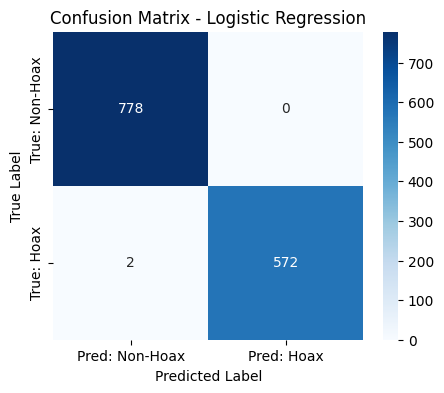

In [ ]:
# ================================================================
# 📦 1. Import Library
# ================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ================================================================
# 🧠 2. Inisialisasi dan Latih Model
# ================================================================
logreg_model = LogisticRegression(max_iter=1000, solver='lbfgs')

print("🚀 Melatih model Logistic Regression...")
logreg_model.fit(X_train_sel, y_train_sel)
print("✅ Model Logistic Regression berhasil dilatih!")

# ================================================================
# 🔍 3. Evaluasi Model
# ================================================================
y_pred = logreg_model.predict(X_test_sel)

accuracy = accuracy_score(y_test_sel, y_pred)
print(f"\n🎯 Akurasi: {accuracy:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_test_sel, y_pred, target_names=["Non-Hoax", "Hoax"]))

# ================================================================
# 📉 4. Confusion Matrix
# ================================================================
cm = confusion_matrix(y_test_sel, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred: Non-Hoax", "Pred: Hoax"], yticklabels=["True: Non-Hoax", "True: Hoax"])
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


**Pelatihan & Evaluasi Model Support Vector Machine (LinearSVC) dengan Fitur Terpilih**

🚀 Melatih model Support Vector Machine (LinearSVC)...
✅ Model SVM berhasil dilatih!

🎯 Akurasi SVM: 1.0000

📊 Classification Report (SVM):
              precision    recall  f1-score   support

    Non-Hoax       1.00      1.00      1.00       778
        Hoax       1.00      1.00      1.00       574

    accuracy                           1.00      1352
   macro avg       1.00      1.00      1.00      1352
weighted avg       1.00      1.00      1.00      1352



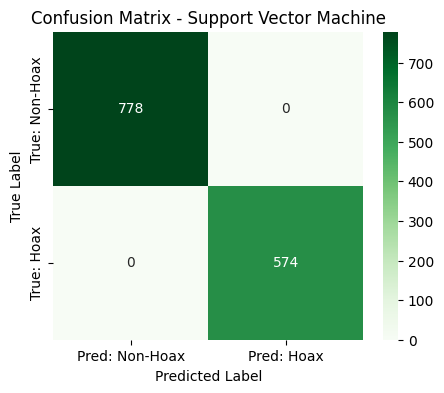

In [ ]:
# ================================================================
# 📦 1. Import Library
# ================================================================
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ================================================================
# 🧠 2. Inisialisasi dan Latih Model
# ================================================================
svm_model = LinearSVC()

print("🚀 Melatih model Support Vector Machine (LinearSVC)...")
svm_model.fit(X_train_sel, y_train_sel)
print("✅ Model SVM berhasil dilatih!")

# ================================================================
# 🔍 3. Evaluasi Model
# ================================================================
y_pred_svm = svm_model.predict(X_test_sel)

accuracy_svm = accuracy_score(y_test_sel, y_pred_svm)
print(f"\n🎯 Akurasi SVM: {accuracy_svm:.4f}")

print("\n📊 Classification Report (SVM):")
print(classification_report(y_test_sel, y_pred_svm, target_names=["Non-Hoax", "Hoax"]))

# ================================================================
# 📉 4. Confusion Matrix
# ================================================================
cm_svm = confusion_matrix(y_test_sel, y_pred_svm)

plt.figure(figsize=(5,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', xticklabels=["Pred: Non-Hoax", "Pred: Hoax"], yticklabels=["True: Non-Hoax", "True: Hoax"])
plt.title("Confusion Matrix - Support Vector Machine")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


**Pelatihan & Evaluasi Model Random Forest dengan Fitur Terpilih**

🚀 Melatih model Random Forest...
✅ Model Random Forest berhasil dilatih!

🎯 Akurasi Random Forest: 1.0000

📊 Classification Report (Random Forest):
              precision    recall  f1-score   support

    Non-Hoax       1.00      1.00      1.00       778
        Hoax       1.00      1.00      1.00       574

    accuracy                           1.00      1352
   macro avg       1.00      1.00      1.00      1352
weighted avg       1.00      1.00      1.00      1352



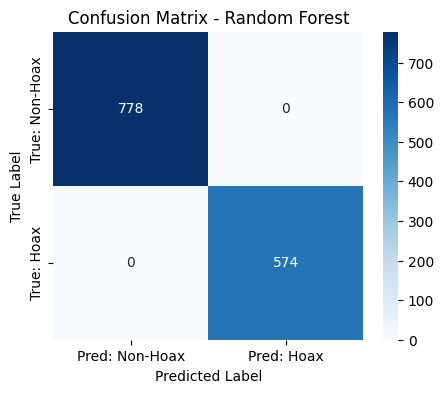

In [ ]:
# ================================================================
# 📦 1. Import Library
# ================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ================================================================
# 🧠 2. Inisialisasi dan Latih Model
# ================================================================
rf_model = RandomForestClassifier(
    n_estimators=200,      # jumlah pohon
    random_state=42,
    n_jobs=-1
)

print("🚀 Melatih model Random Forest...")
rf_model.fit(X_train_sel, y_train_sel)
print("✅ Model Random Forest berhasil dilatih!")

# ================================================================
# 🔍 3. Evaluasi Model
# ================================================================
y_pred_rf = rf_model.predict(X_test_sel)

accuracy_rf = accuracy_score(y_test_sel, y_pred_rf)
print(f"\n🎯 Akurasi Random Forest: {accuracy_rf:.4f}")

print("\n📊 Classification Report (Random Forest):")
print(classification_report(y_test_sel, y_pred_rf, target_names=["Non-Hoax", "Hoax"]))

# ================================================================
# 📉 4. Confusion Matrix
# ================================================================
cm_rf = confusion_matrix(y_test_sel, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred: Non-Hoax", "Pred: Hoax"],
            yticklabels=["True: Non-Hoax", "True: Hoax"])
plt.title("Confusion Matrix - Random Forest")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


**Visualisasi Perbandingan Akurasi Model**

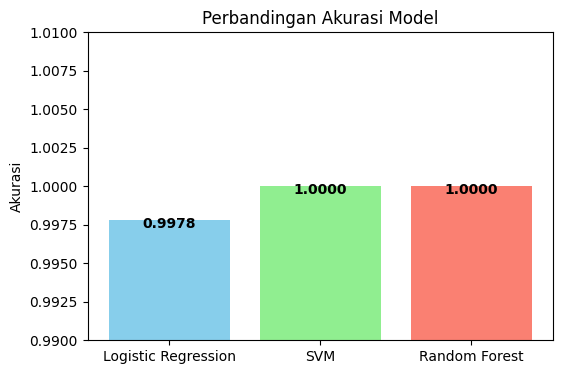

In [ ]:
import matplotlib.pyplot as plt

# Data performa model
models = ["Logistic Regression", "SVM", "Random Forest"]
accuracy = [0.9978, 1.0000, 1.0000]

plt.figure(figsize=(6,4))
plt.bar(models, accuracy, color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Perbandingan Akurasi Model")
plt.ylabel("Akurasi")
plt.ylim(0.99, 1.01)
for i, v in enumerate(accuracy):
    plt.text(i, v - 0.0005, f"{v:.4f}", ha='center', fontweight='bold')
plt.show()


# Bangun Model Word2Vec

**Load Dataset Word2Vec Hasil SMOTE & Pemeriksaan Struktur Data**

In [ ]:
import joblib

# ================================================================
# 1️⃣ LOAD DATA HASIL SMOTE (WORD2VEC)
# ================================================================

# Coba load hasil balancing SMOTE untuk Word2Vec
data_w2v = joblib.load("balanced_word2vec.joblib")

# Cek isi dan struktur objek
print("🔍 Mengecek isi file balanced_word2vec.joblib ...")
print(f"Tipe objek : {type(data_w2v)}")
if isinstance(data_w2v, tuple):
    print(f"Jumlah elemen dalam tuple: {len(data_w2v)}")
    for i, item in enumerate(data_w2v):
        if hasattr(item, 'shape'):
            print(f"➡️ Elemen {i}: tipe {type(item)}, bentuk {item.shape}")
        else:
            print(f"➡️ Elemen {i}: tipe {type(item)}")

# Jika sesuai, pisahkan ke variabel
X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v = data_w2v

print("\n✅ Data Word2Vec hasil SMOTE berhasil dimuat.")
print("📏 Bentuk data train:", X_train_w2v.shape)
print("📏 Bentuk data test :", X_test_w2v.shape)
print("🔸 Jumlah data latih :", len(y_train_w2v))
print("🔹 Jumlah data uji    :", len(y_test_w2v))


🔍 Mengecek isi file balanced_word2vec.joblib ...
Tipe objek : <class 'tuple'>
Jumlah elemen dalam tuple: 4
➡️ Elemen 0: tipe <class 'numpy.ndarray'>, bentuk (6226, 100)
➡️ Elemen 1: tipe <class 'pandas.core.series.Series'>, bentuk (6226,)
➡️ Elemen 2: tipe <class 'numpy.ndarray'>, bentuk (1352, 100)
➡️ Elemen 3: tipe <class 'pandas.core.series.Series'>, bentuk (1352,)

✅ Data Word2Vec hasil SMOTE berhasil dimuat.
📏 Bentuk data train: (6226, 100)
📏 Bentuk data test : (1352, 100)
🔸 Jumlah data latih : 6226
🔹 Jumlah data uji    : 1352


**Pelatihan Model Logistic Regression (Word2Vec)**

Melatih model Logistic Regression dengan Word2Vec...

✅ Model Logistic Regression (Word2Vec) berhasil dilatih!
🎯 Akurasi: 0.9896

📊 Classification Report:
              precision    recall  f1-score   support

    Non-Hoax       0.99      0.99      0.99       778
        Hoax       0.99      0.99      0.99       574

    accuracy                           0.99      1352
   macro avg       0.99      0.99      0.99      1352
weighted avg       0.99      0.99      0.99      1352

🧩 Confusion Matrix (Logistic Regression - Word2Vec):
 [[772   6]
 [  8 566]]


<Figure size 600x500 with 0 Axes>

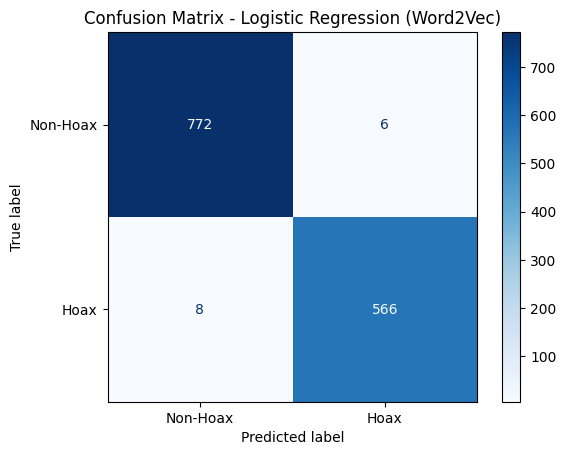

In [ ]:
# ================================================================
# 1️⃣ TRAINING MODEL LOGISTIC REGRESSION (WORD2VEC)
# ================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Inisialisasi model Logistic Regression
logreg_w2v = LogisticRegression(max_iter=1000, random_state=42)

print("Melatih model Logistic Regression dengan Word2Vec...")
logreg_w2v.fit(X_train_w2v, y_train_w2v)

# Prediksi pada data uji
y_pred_logreg_w2v = logreg_w2v.predict(X_test_w2v)

# Evaluasi performa model
acc_logreg_w2v = accuracy_score(y_test_w2v, y_pred_logreg_w2v)
report_logreg_w2v = classification_report(y_test_w2v, y_pred_logreg_w2v, target_names=["Non-Hoax", "Hoax"])

print("\n✅ Model Logistic Regression (Word2Vec) berhasil dilatih!")
print(f"🎯 Akurasi: {acc_logreg_w2v:.4f}")
print("\n📊 Classification Report:")
print(report_logreg_w2v)

# ================================================================
# 🔹 CONFUSION MATRIX UNTUK LOGISTIC REGRESSION (WORD2VEC)
# ================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm_logreg_w2v = confusion_matrix(y_test_w2v, y_pred_logreg_w2v)
print("🧩 Confusion Matrix (Logistic Regression - Word2Vec):\n", cm_logreg_w2v)

# Visualisasi confusion matrix
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_logreg_w2v, display_labels=["Non-Hoax", "Hoax"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Logistic Regression (Word2Vec)")
plt.grid(False)
plt.show()


**Pelatihan Model SVM (LinearSVC) dengan Word2Vec**

Melatih model Support Vector Machine (SVM) dengan Word2Vec...

✅ Model SVM (Word2Vec) berhasil dilatih!
🎯 Akurasi: 0.9970

📊 Classification Report:
              precision    recall  f1-score   support

    Non-Hoax       1.00      1.00      1.00       778
        Hoax       0.99      1.00      1.00       574

    accuracy                           1.00      1352
   macro avg       1.00      1.00      1.00      1352
weighted avg       1.00      1.00      1.00      1352

🧩 Confusion Matrix (SVM - Word2Vec):
 [[775   3]
 [  1 573]]


<Figure size 600x500 with 0 Axes>

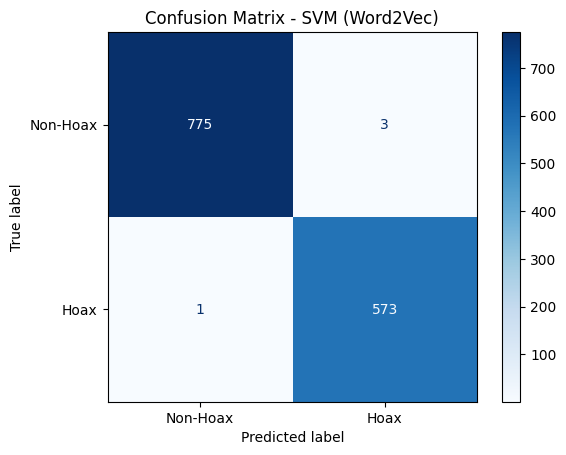

In [ ]:
# ================================================================
# 2️⃣ TRAINING MODEL SUPPORT VECTOR MACHINE (WORD2VEC)
# ================================================================
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# Inisialisasi model SVM Linear
svm_w2v = LinearSVC(random_state=42)

print("Melatih model Support Vector Machine (SVM) dengan Word2Vec...")
svm_w2v.fit(X_train_w2v, y_train_w2v)

# Prediksi pada data uji
y_pred_svm_w2v = svm_w2v.predict(X_test_w2v)

# Evaluasi performa model
acc_svm_w2v = accuracy_score(y_test_w2v, y_pred_svm_w2v)
report_svm_w2v = classification_report(y_test_w2v, y_pred_svm_w2v, target_names=["Non-Hoax", "Hoax"])

print("\n✅ Model SVM (Word2Vec) berhasil dilatih!")
print(f"🎯 Akurasi: {acc_svm_w2v:.4f}")
print("\n📊 Classification Report:")
print(report_svm_w2v)

# ================================================================
# 🔹 CONFUSION MATRIX UNTUK SVM (WORD2VEC)
# ================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm_svm_w2v = confusion_matrix(y_test_w2v, y_pred_svm_w2v)
print("🧩 Confusion Matrix (SVM - Word2Vec):\n", cm_svm_w2v)

# Visualisasi confusion matrix
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_w2v, display_labels=["Non-Hoax", "Hoax"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - SVM (Word2Vec)")
plt.grid(False)
plt.show()


**Pelatihan Model Random Forest (Word2Vec)**

Melatih model Random Forest dengan Word2Vec...

✅ Model Random Forest (Word2Vec) berhasil dilatih!
🎯 Akurasi: 0.9815

📊 Classification Report:
              precision    recall  f1-score   support

    Non-Hoax       0.98      0.99      0.98       778
        Hoax       0.99      0.97      0.98       574

    accuracy                           0.98      1352
   macro avg       0.98      0.98      0.98      1352
weighted avg       0.98      0.98      0.98      1352

🧩 Confusion Matrix (Random Forest - Word2Vec):
 [[771   7]
 [ 18 556]]


<Figure size 600x500 with 0 Axes>

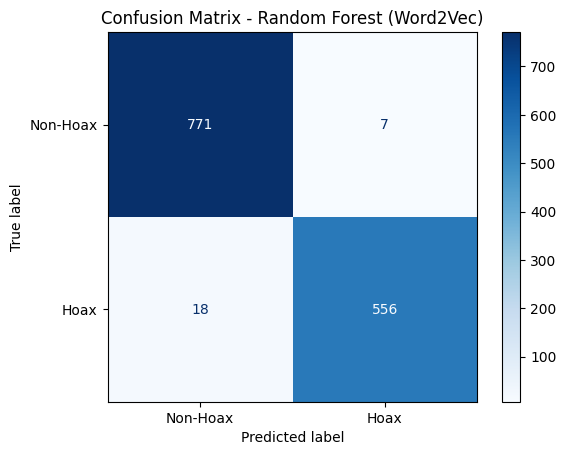

In [ ]:
# ================================================================
# 3️⃣ TRAINING MODEL RANDOM FOREST (WORD2VEC)
# ================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Inisialisasi model Random Forest
rf_w2v = RandomForestClassifier(
    n_estimators=200,     # jumlah pohon
    random_state=42,
    n_jobs=-1             # gunakan semua core CPU
)

print("Melatih model Random Forest dengan Word2Vec...")
rf_w2v.fit(X_train_w2v, y_train_w2v)

# Prediksi pada data uji
y_pred_rf_w2v = rf_w2v.predict(X_test_w2v)

# Evaluasi performa model
acc_rf_w2v = accuracy_score(y_test_w2v, y_pred_rf_w2v)
report_rf_w2v = classification_report(y_test_w2v, y_pred_rf_w2v, target_names=["Non-Hoax", "Hoax"])

print("\n✅ Model Random Forest (Word2Vec) berhasil dilatih!")
print(f"🎯 Akurasi: {acc_rf_w2v:.4f}")
print("\n📊 Classification Report:")
print(report_rf_w2v)

# ================================================================
# 🔹 CONFUSION MATRIX UNTUK RANDOM FOREST (WORD2VEC)
# ================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm_rf_w2v = confusion_matrix(y_test_w2v, y_pred_rf_w2v)
print("🧩 Confusion Matrix (Random Forest - Word2Vec):\n", cm_rf_w2v)

# Visualisasi confusion matrix
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_w2v, display_labels=["Non-Hoax", "Hoax"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Random Forest (Word2Vec)")
plt.grid(False)
plt.show()


# VISUALISASI PERBANDINGAN MODEL TF-IDF vs WORD2VEC

/tmp/ipython-input-4291069896.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette="coolwarm")


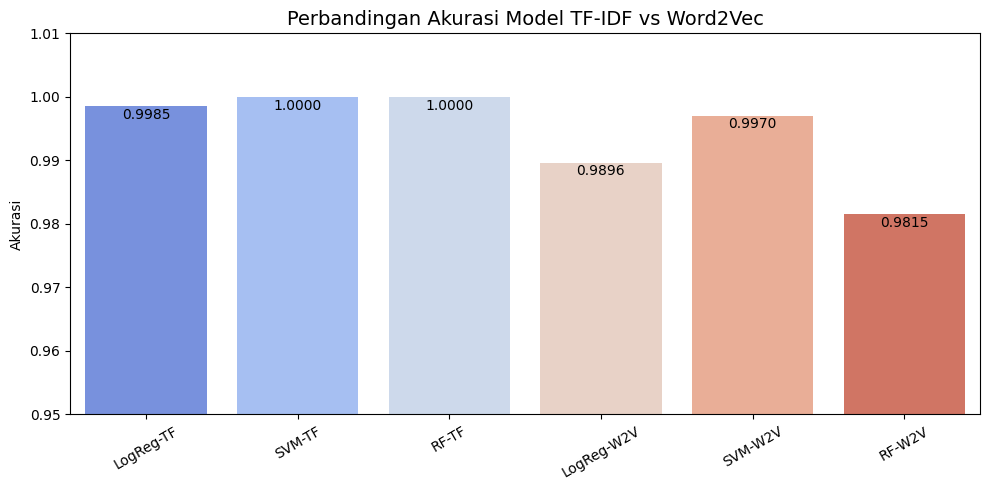

In [ ]:
# ================================================================
# 📌 PREPARASI: Pastikan prediksi TF-IDF tersedia
# ================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# =======================
# 1️⃣ Logistic Regression TF-IDF
# =======================
if 'y_pred_logreg_tfidf' not in globals():
    logreg_tfidf = LogisticRegression(max_iter=1000, random_state=42)
    logreg_tfidf.fit(X_train_sel, y_train_sel)
    y_pred_logreg_tfidf = logreg_tfidf.predict(X_test_sel)
    acc_logreg_tfidf = accuracy_score(y_test_sel, y_pred_logreg_tfidf)

# =======================
# 2️⃣ SVM TF-IDF
# =======================
if 'y_pred_svm_tfidf' not in globals():
    svm_tfidf = LinearSVC(random_state=42)
    svm_tfidf.fit(X_train_sel, y_train_sel)
    y_pred_svm_tfidf = svm_tfidf.predict(X_test_sel)
    acc_svm_tfidf = accuracy_score(y_test_sel, y_pred_svm_tfidf)

# =======================
# 3️⃣ Random Forest TF-IDF
# =======================
if 'y_pred_rf_tfidf' not in globals():
    rf_tfidf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf_tfidf.fit(X_train_sel, y_train_sel)
    y_pred_rf_tfidf = rf_tfidf.predict(X_test_sel)
    acc_rf_tfidf = accuracy_score(y_test_sel, y_pred_rf_tfidf)



# ================================================================
# 📊 5️⃣ Visualisasi Perbandingan Akurasi
# ================================================================
model_names = ["LogReg-TF", "SVM-TF", "RF-TF", "LogReg-W2V", "SVM-W2V", "RF-W2V"]
accuracies = [
    acc_logreg_tfidf,
    acc_svm_tfidf,
    acc_rf_tfidf,
    acc_logreg_w2v,
    acc_svm_w2v,
    acc_rf_w2v
]

plt.figure(figsize=(10, 5))
sns.barplot(x=model_names, y=accuracies, palette="coolwarm")
plt.title("Perbandingan Akurasi Model TF-IDF vs Word2Vec", fontsize=14)
plt.ylabel("Akurasi")
plt.ylim(0.95, 1.01)
plt.xticks(rotation=30)

for i, acc in enumerate(accuracies):
    plt.text(i, acc - 0.002, f"{acc:.4f}", ha='center', color='black')

plt.tight_layout()
plt.show()


In [ ]:
import joblib

# Load data hasil SMOTE
X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf = joblib.load("balanced_tfidf.joblib")

print("X_train_tfidf:", X_train_tfidf.shape)
print("y_train_tfidf:", y_train_tfidf.shape)

print("X_test_tfidf:", X_test_tfidf.shape)
print("y_test_tfidf:", y_test_tfidf.shape)

# ================================================================
# MLP dengan TF-IDF
# ================================================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

print("🚀 Melatih MLP dengan TF-IDF...")

mlp_tfidf = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

mlp_tfidf.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_tfidf = mlp_tfidf.fit(
    X_train_tfidf.toarray(),
    y_train_tfidf,
    validation_data=(X_test_tfidf.toarray(), y_test_tfidf),
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# Evaluasi
loss_tfidf, acc_tfidf = mlp_tfidf.evaluate(X_test_tfidf.toarray(), y_test_tfidf, verbose=0)
print(f"\n🎯 Akurasi MLP (TF-IDF): {acc_tfidf:.4f}")


X_train_tfidf: (6226, 5000)
y_train_tfidf: (6226,)
X_test_tfidf: (1352, 5000)
y_test_tfidf: (1352,)
🚀 Melatih MLP dengan TF-IDF...
Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.9122 - loss: 0.2158 - val_accuracy: 0.9985 - val_loss: 0.0058
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 4.7713e-05
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 1.0000 - loss: 1.5707e-05 - val_accuracy: 1.0000 - val_loss: 1.4142e-04
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 1.0000 - loss: 7.7696e-06 - val_accuracy: 1.0000 - val_loss: 1.8486e-04
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 1.0000 - loss: 8.1178e-06 - val_accuracy: 1.0000 - val_loss: 2.1973e-04
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 1.0000 - loss: 2.8070e-06 - val_accuracy: 1.0000 - val_loss: 2.4290e-04
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - acc

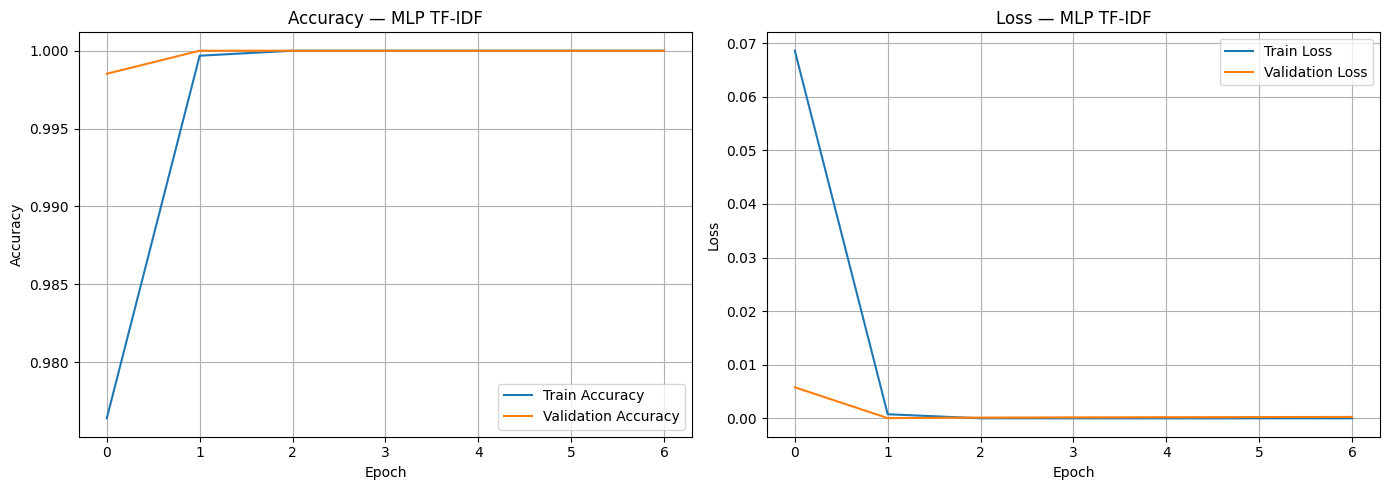

In [ ]:
import matplotlib.pyplot as plt

# ================================================================
# 📊 Grafik Akurasi & Loss — MLP TF-IDF
# ================================================================
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_tfidf.history['accuracy'], label='Train Accuracy')
plt.plot(history_tfidf.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy — MLP TF-IDF")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_tfidf.history['loss'], label='Train Loss')
plt.plot(history_tfidf.history['val_loss'], label='Validation Loss')
plt.title("Loss — MLP TF-IDF")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

print("🚀 Melatih MLP dengan Word2Vec...")

mlp_w2v = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_w2v.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

mlp_w2v.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_w2v = mlp_w2v.fit(
    X_train_w2v,
    y_train_w2v,
    validation_data=(X_test_w2v, y_test_w2v),
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# Evaluasi
loss_w2v, acc_w2v = mlp_w2v.evaluate(X_test_w2v, y_test_w2v, verbose=0)
print(f"\n🎯 Akurasi MLP (Word2Vec): {acc_w2v:.4f}")


🚀 Melatih MLP dengan Word2Vec...
Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8983 - loss: 0.2616 - val_accuracy: 0.9874 - val_loss: 0.0302
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9906 - loss: 0.0325 - val_accuracy: 0.9933 - val_loss: 0.0204
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9907 - loss: 0.0264 - val_accuracy: 0.9941 - val_loss: 0.0179
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9949 - loss: 0.0209 - val_accuracy: 0.9948 - val_loss: 0.0148
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9929 - loss: 0.0209 - val_accuracy: 0.9882 - val_loss: 0.0284
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9947 - loss: 0.0136 - val_accuracy: 0.9963 - val_loss: 0.0126
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9917 - loss: 0.0182 - val_accuracy: 0.9919 - val_loss: 0.0229
Epoch 8/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.99

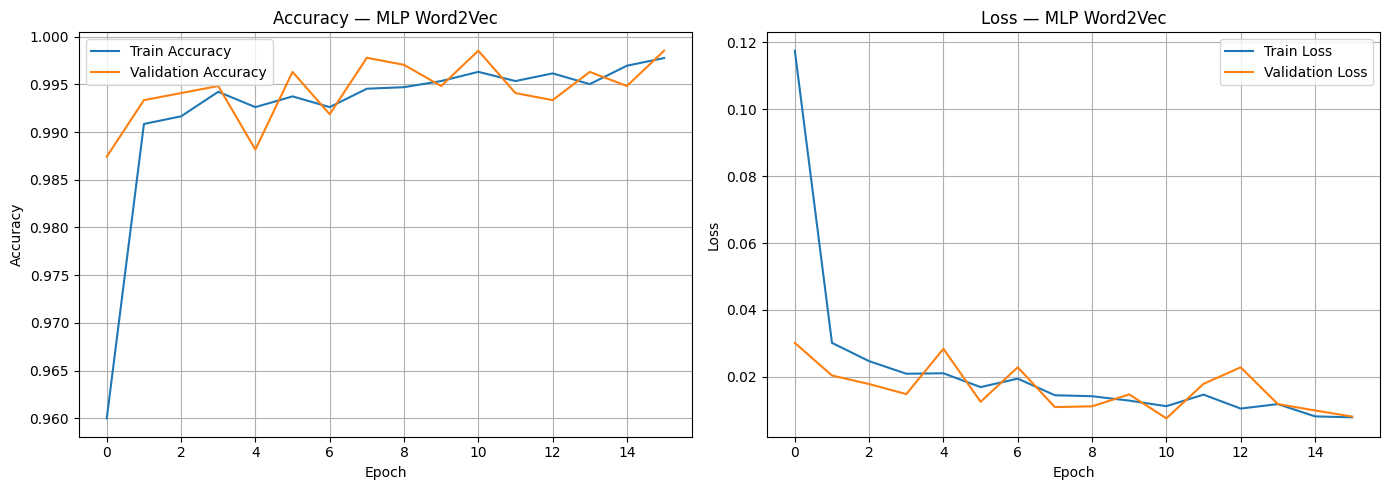

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_w2v.history['accuracy'], label='Train Accuracy')
plt.plot(history_w2v.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy — MLP Word2Vec")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_w2v.history['loss'], label='Train Loss')
plt.plot(history_w2v.history['val_loss'], label='Validation Loss')
plt.title("Loss — MLP Word2Vec")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# ================================================================
# 1️⃣ AMBIL 10 SAMPEL DATA UJI
# ================================================================
N = 10

# TF-IDF (hasil seleksi fitur)
idx_tfidf = np.random.choice(X_test_sel.shape[0], N, replace=False)
samples_tfidf = X_test_sel[idx_tfidf]

if isinstance(y_test_sel, pd.Series):
    labels_tfidf = y_test_sel.iloc[idx_tfidf].values
else:
    labels_tfidf = y_test_sel[idx_tfidf]

# Word2Vec
idx_w2v = np.random.choice(X_test_w2v.shape[0], N, replace=False)
samples_w2v = X_test_w2v[idx_w2v]

if isinstance(y_test_w2v, pd.Series):
    labels_w2v = y_test_w2v.iloc[idx_w2v].values
else:
    labels_w2v = y_test_w2v[idx_w2v]


# ================================================================
# 2️⃣ FUNGSI BANTU PROBABILITAS
# ================================================================
def get_proba(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        return 1 / (1 + np.exp(-scores))
    else:
        return np.array([None] * X.shape[0])


# ================================================================
# 3️⃣ PREDIKSI SEMUA MODEL
# ================================================================
results = []

def append_results(model_name, labels, preds, probas):
    for i in range(len(labels)):
        results.append([
            model_name,
            int(labels[i]),
            int(preds[i]),
            float(probas[i]) if probas[i] is not None else None
        ])

# TF-IDF (HASIL SELEKSI FITUR)
pred_logreg_tfidf = logreg_model.predict(samples_tfidf)
proba_logreg_tfidf = get_proba(logreg_model, samples_tfidf)

pred_svm_tfidf = svm_model.predict(samples_tfidf)
proba_svm_tfidf = get_proba(svm_model, samples_tfidf)

pred_rf_tfidf = rf_model.predict(samples_tfidf)
proba_rf_tfidf = get_proba(rf_model, samples_tfidf)

append_results("LogReg (TF-IDF)", labels_tfidf, pred_logreg_tfidf, proba_logreg_tfidf)
append_results("SVM (TF-IDF)", labels_tfidf, pred_svm_tfidf, proba_svm_tfidf)
append_results("Random Forest (TF-IDF)", labels_tfidf, pred_rf_tfidf, proba_rf_tfidf)

# Word2Vec
pred_logreg_w2v = logreg_w2v.predict(samples_w2v)
proba_logreg_w2v = get_proba(logreg_w2v, samples_w2v)

pred_svm_w2v = svm_w2v.predict(samples_w2v)
proba_svm_w2v = get_proba(svm_w2v, samples_w2v)

pred_rf_w2v = rf_w2v.predict(samples_w2v)
proba_rf_w2v = get_proba(rf_w2v, samples_w2v)

append_results("LogReg (W2V)", labels_w2v, pred_logreg_w2v, proba_logreg_w2v)
append_results("SVM (W2V)", labels_w2v, pred_svm_w2v, proba_svm_w2v)
append_results("Random Forest (W2V)", labels_w2v, pred_rf_w2v, proba_rf_w2v)


# ================================================================
# 4️⃣ MASUKKAN KE TABEL
# ================================================================
df_results = pd.DataFrame(results, columns=[
    "Model",
    "Label Asli",
    "Prediksi",
    "Probabilitas"
])

print("\n==============================")
print("📌 HASIL PREDIKSI NYATA SEMUA MODEL")
print("==============================\n")
print(df_results)



📌 HASIL PREDIKSI NYATA SEMUA MODEL

                     Model  Label Asli  Prediksi  Probabilitas
0          LogReg (TF-IDF)           0         0      0.028008
1          LogReg (TF-IDF)           0         0      0.043918
2          LogReg (TF-IDF)           1         1      0.987537
3          LogReg (TF-IDF)           1         1      0.982509
4          LogReg (TF-IDF)           0         0      0.084798
5          LogReg (TF-IDF)           0         0      0.040733
6          LogReg (TF-IDF)           0         0      0.031487
7          LogReg (TF-IDF)           0         0      0.017157
8          LogReg (TF-IDF)           0         0      0.038985
9          LogReg (TF-IDF)           0         0      0.035408
10            SVM (TF-IDF)           0         0      0.235844
11            SVM (TF-IDF)           0         0      0.260315
12            SVM (TF-IDF)           1         1      0.894955
13            SVM (TF-IDF)           1         1      0.839408
14            SVM 

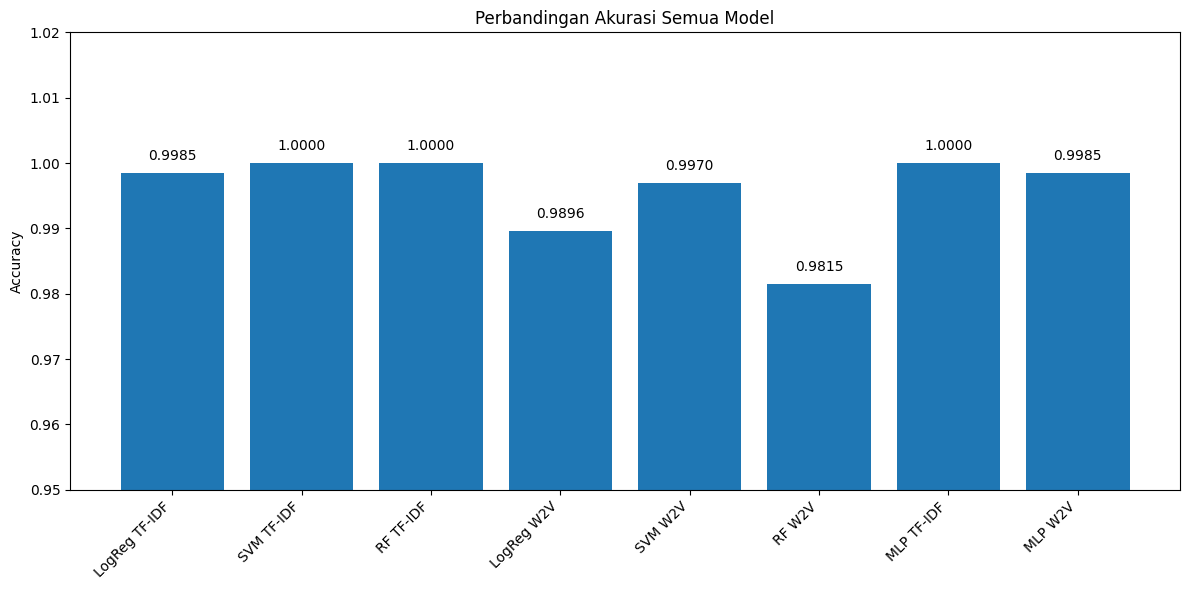

In [ ]:
import matplotlib.pyplot as plt

# model names and accuracies
model_names = [
    "LogReg TF-IDF",
    "SVM TF-IDF",
    "RF TF-IDF",
    "LogReg W2V",
    "SVM W2V",
    "RF W2V",
    "MLP TF-IDF",
    "MLP W2V"
]

accuracies = [
    0.9985,
    1.0,
    1.0,
    0.9896,
    0.9970,
    0.9815,
    1.0,
    0.9985
]

plt.figure(figsize=(12,6))
plt.bar(model_names, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Perbandingan Akurasi Semua Model")
plt.ylim(0.95, 1.02)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.002, f"{acc:.4f}", ha='center')

plt.tight_layout()
plt.show()


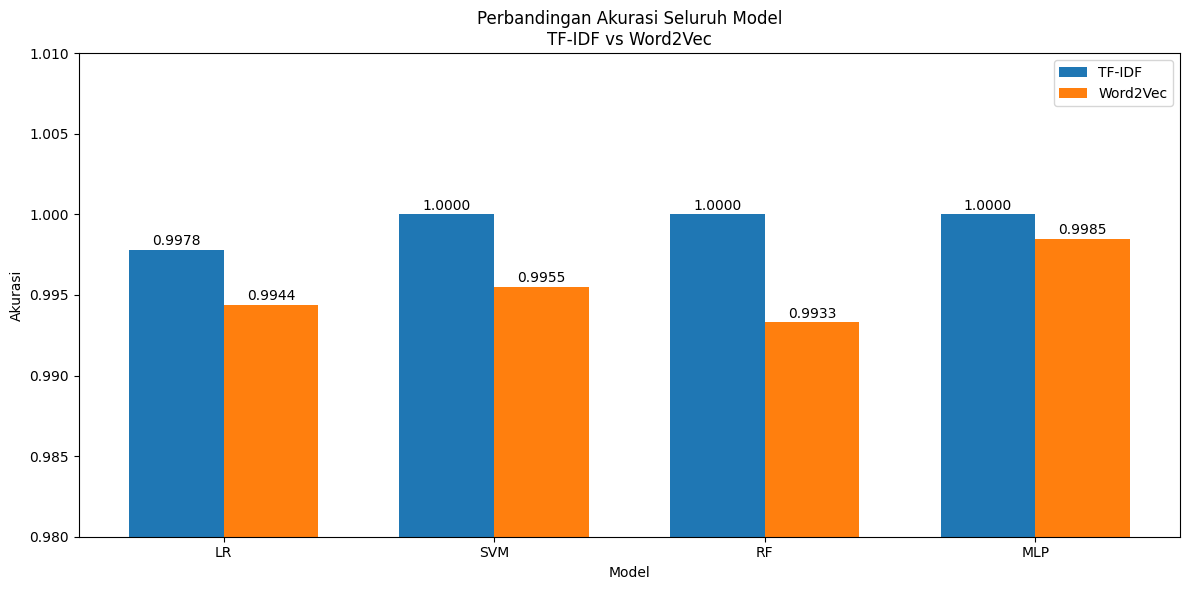

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------
# DATA AKURASI SEMUA MODEL
# (silakan sesuaikan kalau Anda ingin update hasil baru)
# -------------------------------------------

models = ["LR", "SVM", "RF", "MLP"]

# Akurasi TF-IDF
tfidf_scores = [0.9978, 1.0000, 1.0000, 1.0000]

# Akurasi Word2Vec
w2v_scores = [0.9944, 0.9955, 0.9933, 0.9985]

# -------------------------------------------
# VISUALISASI
# -------------------------------------------

x = np.arange(len(models))
width = 0.35  # lebar bar

plt.figure(figsize=(12, 6))

# Bar TF-IDF
plt.bar(x - width/2, tfidf_scores, width, label="TF-IDF")

# Bar Word2Vec
plt.bar(x + width/2, w2v_scores, width, label="Word2Vec")

# Menambahkan label angka di atas bar
for i, v in enumerate(tfidf_scores):
    plt.text(i - width/2, v + 0.0001, f"{v:.4f}", ha='center', va='bottom')

for i, v in enumerate(w2v_scores):
    plt.text(i + width/2, v + 0.0001, f"{v:.4f}", ha='center', va='bottom')

# Pengaturan tampilan grafik
plt.xticks(x, models)
plt.xlabel("Model")
plt.ylabel("Akurasi")
plt.title("Perbandingan Akurasi Seluruh Model\nTF-IDF vs Word2Vec")
plt.ylim(0.98, 1.01)
plt.legend()
plt.tight_layout()

plt.show()
